####################################################################################
# Diabetes Prediction with Logistic Regression
#####################################################################################

# İş Problemi

### özellikleri belirtildiğinde kişilerin diyabet hastası olup
### olmadıklarını tahöin edebilecek bir makine öğrenmesi
### modeli geliştirebilir miyiz ? 

### Veri seti ABD'deki ulusal diyabet-sindirim-böbrek hastalıkları wnstitülerinde 
### tutulan büyük veri setinin parçasıdır. ABD deki Arizona Eyaletinin en büyük 5. ### şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima İndian kadınları 
### üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve  ### 8 sayısal bağımsız değişken oluşmaktadır. Hedef değişken 
### "outcome" olarak ### ### belirtilmiş # olup; 1 diyabet test sonucunun pozitif oluşumu, 0 ise negatif oluşunu      
### belirtmektedir.

# Değişkenler
### Pregnancies: Hamilelik sayısı
### Glucose: Glikoz
### BloodPressure: Kan Basıncı
### SkinThickness: cilt kalınlığı
### Insulin: İnsülin
### BMI: beden kitle indeksi
### DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
### age: yaş
### Outcome: kişinin diyabet olup olmadığı bilgisi. hastalığa sahip (1) yada değil (0)

### 1. Exploratory Data Analysis
### 2. Data Preprocessing
### 3. Model & Prediction
### 4. Model Evaluation
### 5. Model Validation : Holdout
### 6. Model Validation: 10-Fold Cross Validation
### 7. Prediction for a new observation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_validate


In [4]:
import sklearn
print(sklearn.__version__)

1.4.2


In [5]:
def outlier_threesholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [6]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_threesholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [7]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threesholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [8]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x) ## virgülden sonra üç basamak için
pd.set_option("display.width", 500)


In [9]:
df = pd.read_csv("DATA/diabetes.csv")

In [10]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [11]:
df.shape

(768, 9)

#############################
#### Target'ın Analizi (Bağımlı Değişken = Kişinin diyabet olup olmadığı bilgisi)
#############################

In [12]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

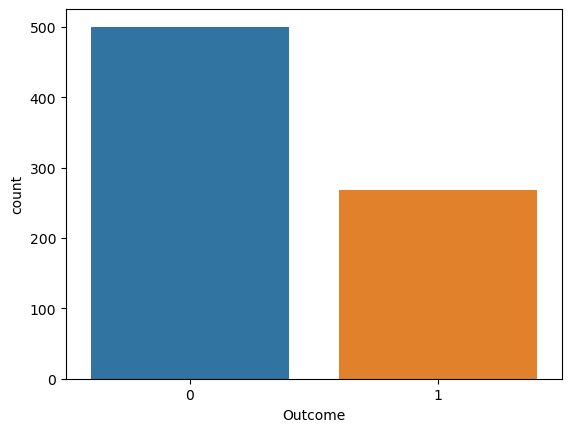

In [13]:
sns.countplot(x="Outcome", data=df)
plt.show()

In [14]:
100 * df["Outcome"].value_counts() / len(df)

Outcome
0   65.104
1   34.896
Name: count, dtype: float64

#####################################
#### Feature'ların (Bağımsız Değişkenler) Analizi
#####################################

In [15]:
df.describe().T  ### sadece sayısal değişkenleri getirir ve onları özetler.

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


###### Sayısal değişkenlerin grafiklerle gösterilmesi denince akla gelinecek 
###### iki grafik türü vardır.
###### Bunlar: Histogram ve Kutu grafiği
###### BloodPressure: Kan Basıncı için histogram

<function matplotlib.pyplot.show(close=None, block=None)>

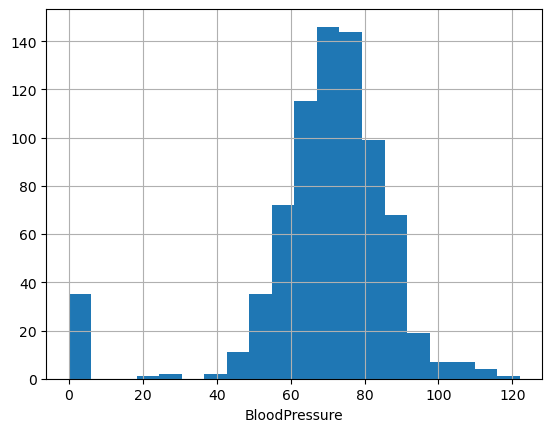

In [16]:
df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.show

#### Tabiki de her bir sayısal değişken için histogram grafiği çizdirebiliriz fakat
#### tek tek uğraşmak yerine fonksiyon tanımlayarak her biri için çizdirebiliriz.

In [17]:
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)

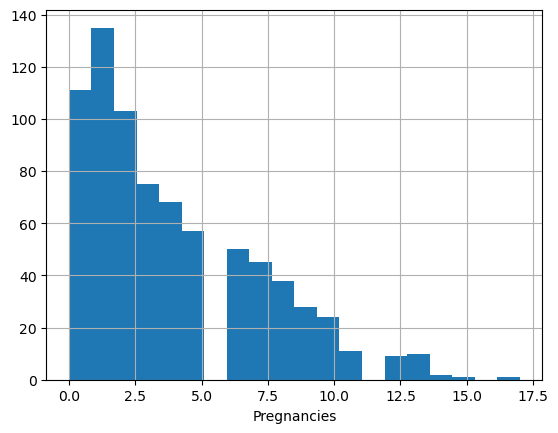

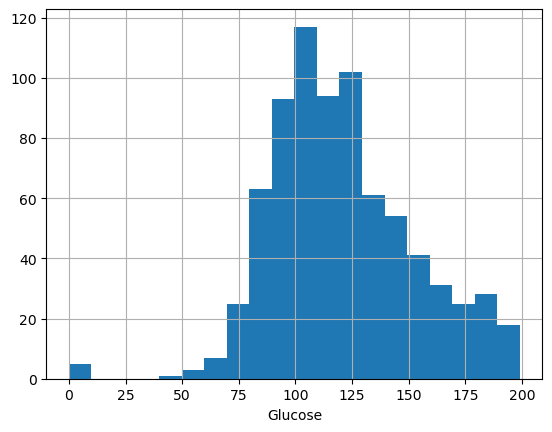

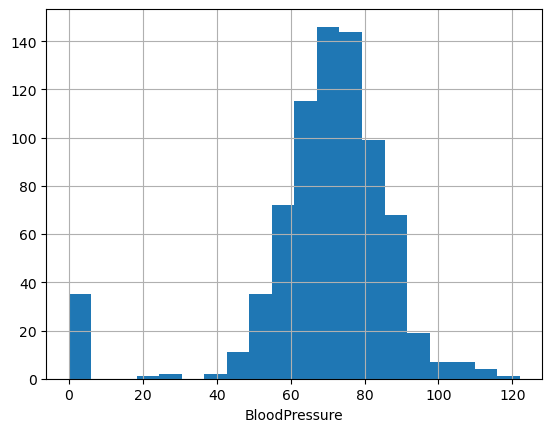

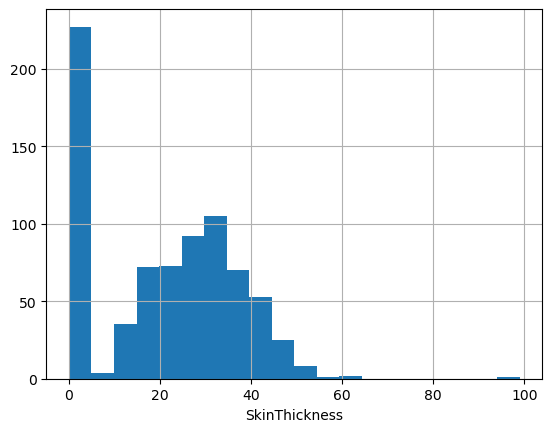

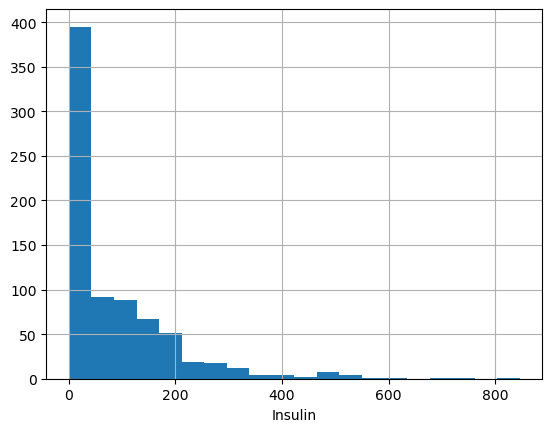

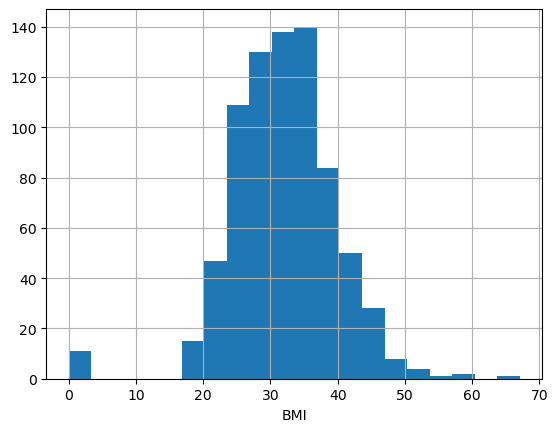

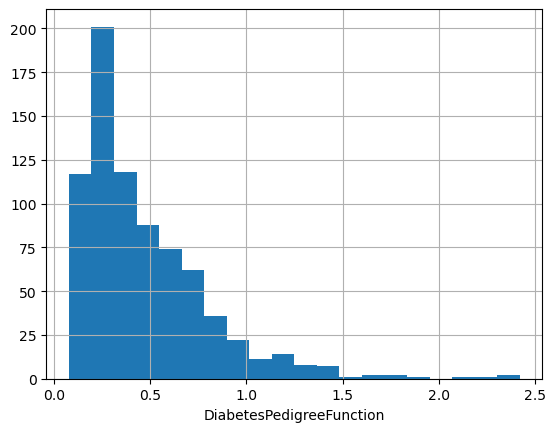

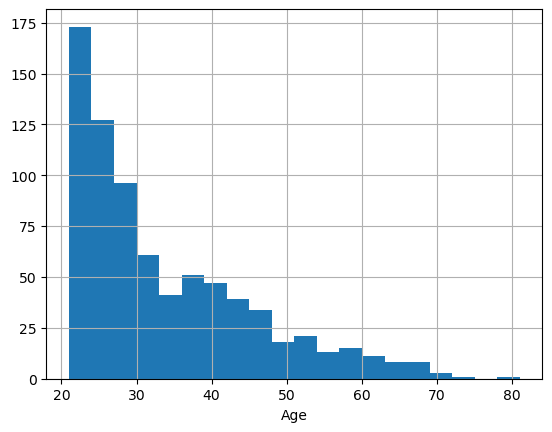

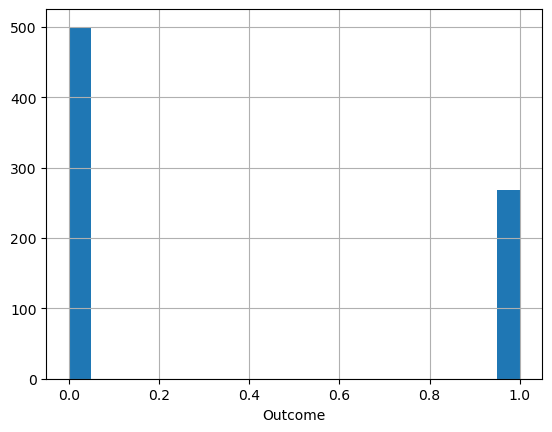

In [18]:
for col in df.columns:
    plot_numerical_col(df, col)

#### bağımlı değişkenimizin histogramını vermesinde bir sakınca yoktur fakat
#### bunun istenmemesi durumunda list comp. metodu ile dışarıda bırakıp 
#### tekrardan döngüye sokabiliriz.

In [19]:
cols = [col for col in df.columns if "Outcome" not in col]

In [20]:
cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

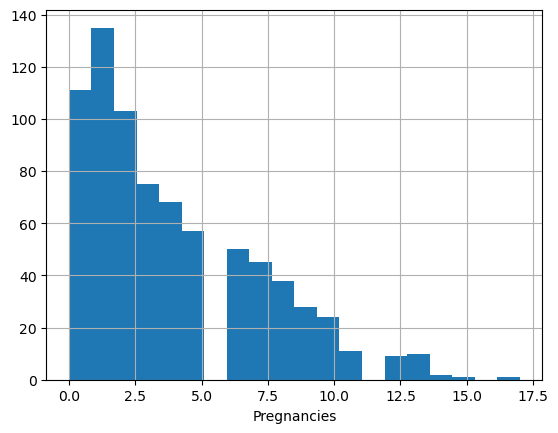

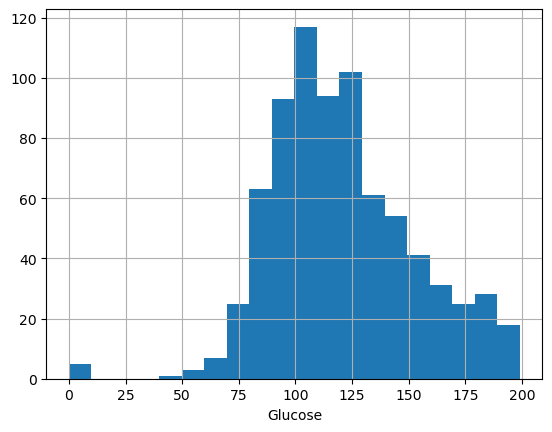

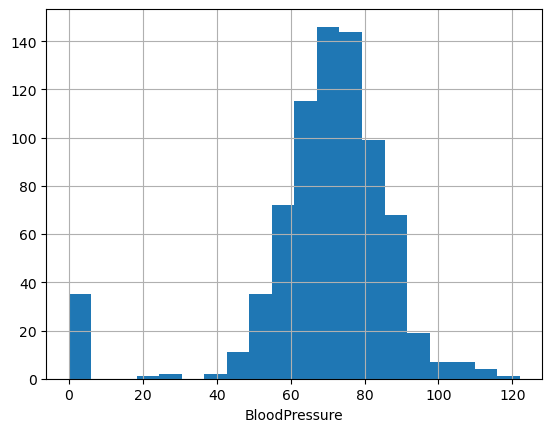

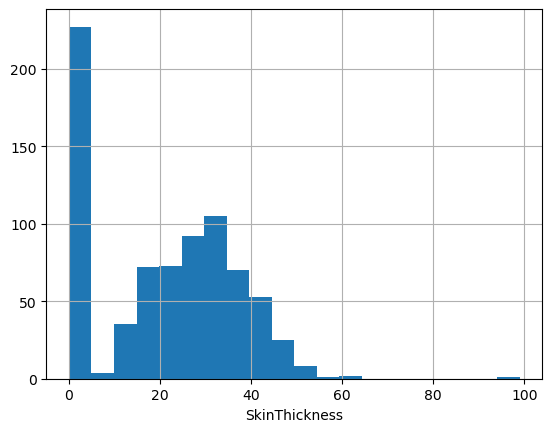

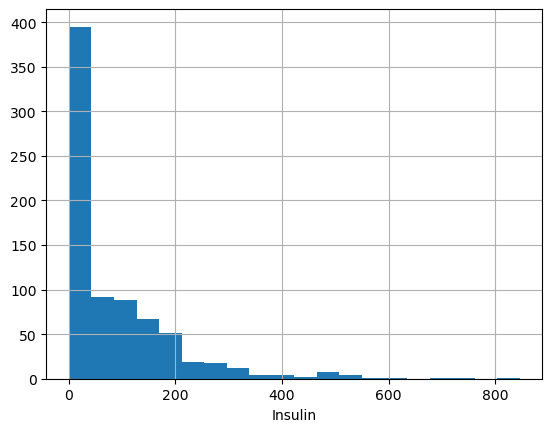

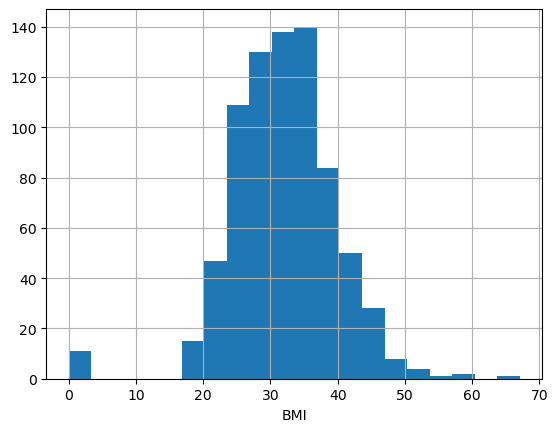

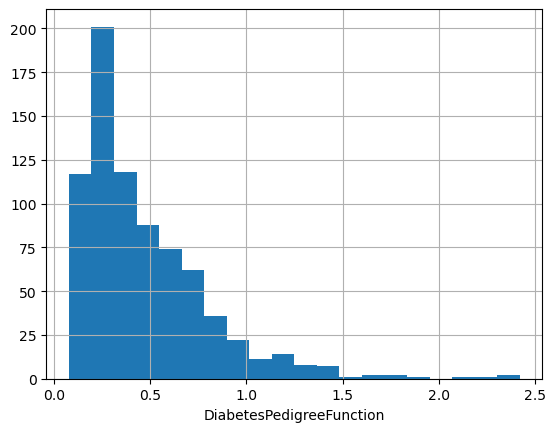

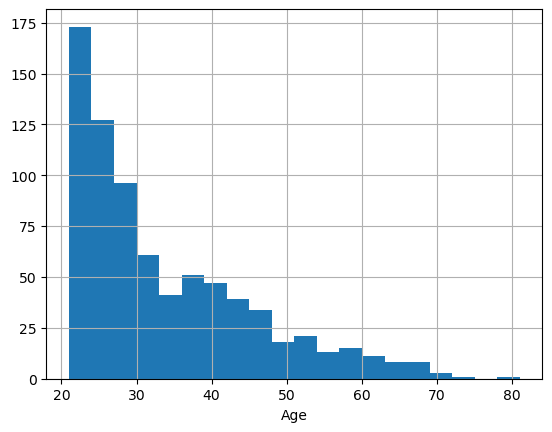

In [21]:
for col in cols:
    plot_numerical_col(df, col)

In [22]:
df.groupby("Outcome").agg({"Pregnancies": "mean"})

,Pregnancies
Outcome,
0,3.298
1,4.866


#### burada ise diyabet olup olmama durumuna göre hamile olma ortalamasını inceledik.

In [23]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col:"mean"}), end="\n\n\n")

#### burada ise target_summary_with_num fonks ile numerik değişkenleri target ile analiz et hepsiyle teker teker anlamına geliyor.

In [24]:
for col in cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




#################################################################
### Data Peprocessing (Veri Ön İşleme)
#################################################################

In [34]:
df.shape

(768, 9)

In [35]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0.000,33.600,0.627,50,1
1,1,85,66,29,0.000,26.600,0.351,31,0
2,8,183,64,0,0.000,23.300,0.672,32,1
3,1,89,66,23,94.000,28.100,0.167,21,0
4,0,137,40,35,168.000,43.100,2.288,33,1


In [36]:
df.isnull().sum()          ## eksik değer var mı ?

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.637,114.243,0.000,0.000,30.500,127.250,732.500
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


#### normalde bakıldığında kan basıncının 0 olması mantıklı değildir. burada 0 ile atamalar olduğu gözlenir. biz bu kısımla ilgilenmeyeceğiz.


In [38]:
for col in cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


### burada numeric değişkenlerimizde alt veya üst uç değerleri var mı onun bilgisini verir.

In [39]:
replace_with_thresholds(df, "Insulin")

#### replace_with_thresholds = aykırı değeri bulununan bağımsız değerler için hesaplanan eşik değeri ile değiştirme yöntemidir. Bunu çalıştırdıktan sonra tekrar check_outlier çalıştırılırsa ınsulun true iken false olduğunu gözlemlemiş oluruz.

## DEĞİŞKENLERİ ÖLÇEKLENDİRMEK

In [40]:
for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

### medyan aykırı değerlere duyarsızdır bu yuzden robust yöntemi kullanılır.

In [41]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


############################################################################
# MODELLEME & TAHMİN 
############################################################################

In [42]:
y = df["Outcome"]

In [43]:
X = df.drop(["Outcome"], axis=1)

In [44]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [45]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235
...,...,...,...,...,...,...,...,...
763,1.400,-0.388,0.222,0.781,1.175,0.097,-0.527,2.000
764,-0.200,0.121,-0.111,0.125,-0.240,0.516,-0.085,-0.118
765,0.400,0.097,0.000,0.000,0.640,-0.624,-0.333,0.059
766,-0.400,0.218,-0.667,-0.719,-0.240,-0.204,-0.061,1.059


In [46]:
log_model = LogisticRegression().fit(X, y)

In [47]:
log_model.intercept_

array([-1.23367499])

In [48]:
log_model.coef_

array([[ 0.60026858,  1.41864488, -0.2317767 ,  0.02249032, -0.14660392,
         0.81662929,  0.35519151,  0.25514769]])

In [49]:
y_pred = log_model.predict(X)

In [50]:
y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

In [51]:
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

######################################################################
# MODEL BAŞARI DEĞERLENDİRME
######################################################################

In [52]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot = True, fmt = ".0f")
    plt.xlabel("y_pred")
    plt.ylabel("y")
    plt.title("Accuracy Score: {0}".format(acc), size = 10)
    plt.show()

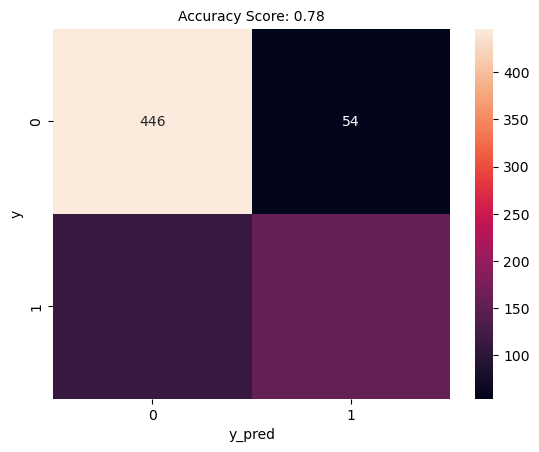

In [53]:
plot_confusion_matrix(y, y_pred)

In [54]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



### accuracy:0.78 
### precision: 0.74
### recall: 0.58
### f1-score: 0.65

In [55]:
y_prob = log_model.predict_proba(X)[:, 1]

In [56]:
roc_auc_score(y, y_prob)

0.8394104477611941

#################################################################################
# Model Doğrulama ( Model Validation ) TEST ETME
#################################################################################

# 1) HOLDOUT YÖNTEMİ

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20, random_state=17)

In [58]:
log_model = LogisticRegression().fit(X_train, y_train)

In [59]:
y_pred = log_model.predict(X_test)

In [60]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)

In [61]:
y_prob = log_model.predict_proba(X_test)[:, 1]

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



In [64]:
eğitim ve test setinden geçmeden önceki bulduğumuz değerler ile geçmiş halindeki ile çok büyük farklar yoktur fakat model görmediği veride zannettiği kadar başarılı olmayabilir bu yüden model doğrulama yapılmalıdır.

SyntaxError: invalid syntax (3242735346.py, line 1)

#### bir de auc değerine bakalım

In [65]:
roc_auc_score(y_test, y_prob)

0.8755652016639537

######################################################################################
# 10 Katlı Çapraz Doğrulama ( 10-Fold Cross Validation )
######################################################################################

#### Modelimizde öyle bir işlem yapılmalı ki doğrulama işlemi için en doğru modeli bize versin ve bu yüzden 10 katlı çapraz doğrulama işlemi yapılır.

In [66]:
y = df["Outcome"]

In [67]:
X = df.drop(["Outcome"], axis=1)

In [68]:
log_model = LogisticRegression().fit(X, y)

In [108]:
cv_results = cross_validate(log_model,
                            X,y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [110]:
cv_results["test_accuracy"]

array([0.77272727, 0.74675325, 0.75324675, 0.81699346, 0.77124183])

### yukarıdaki 5 değer ise 5 katlı çapraz doğrulama da her bir aşamadaki accuracy değerlerimiz oluyor eğer bunların ortalamasını alırsak tek bir değer elde etmiş oluruz.


In [114]:
cv_results["test_accuracy"].mean()

0.7721925133689839

In [115]:
cv_results["test_recall"].mean()

0.5747030048916841

In [116]:
cv_results["test_precision"].mean()

0.7192472060223519

In [117]:
cv_results["test_f1"].mean()

0.6371421090986309

In [118]:
cv_results["test_roc_auc"].mean()

0.832879105520615

### şimdi üç tane karşılaştırma yapacağız
### bir genel modelleme sonucu accuracy vs.
### iki haldout yöntemi sonucu accuracy vs.
### üç ise 5 katlı çapraz doğrulama sonucu accuracy vs.

In [ ]:
verimiz dengeli bir veri değil accuracy değerine bakarsak ne iyi ne kötü diyebiliriz.


In [119]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [120]:
random_user = X.sample(1, random_state=45)

In [121]:
random_user

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
195,0.400,0.994,0.667,0.562,1.411,0.796,0.059,0.000


In [122]:
log_model.predict(random_user)

array([1], dtype=int64)

### random bir kullancıcı seçip kurduğmuz modelde tahmin işlemi yaptık ve sonucunda da bu kişi diyabettir somucunu vermiş oldu.